# Ising Model simulation

Course project for "Introduction to Scientific Computing"

Author: Dmytro Fedoriaka

Skoltech, 2017


# 1. Ising Model
In this work we will consider Ising model on isotropic square lattice in zero external field.
It's lattice $S$ of size $N \times N$, each element of which can be either 1 or -1 (i.e. $S \in \{-1,1\}^{N \times N}$).
Energy of this lattice is given by formula:

$$E = -J \sum_{i=0}^{N-1}  \sum_{j=0}^{N-1} S_{i,j} (S_{i,j+1} + S_{i+1,j}).$$

We will consider periodical border condition: here and further we assume that indices of lattice belongs to $\mathbb{Z}_{N}$, which means that $0 \equiv N$.

When $N \to \infty$, behaviour of this lattice tends to behaviour of Ising model on infinite lattice, which is well studied.

We will focus on two main parameters: energy per site:

$$E_1 = -\frac{J}{N^2}\sum_{i=0}^{N-1}  \sum_{j=0}^{N-1} S_{i,j} (S_{i,j+1} + S_{i+1,j}),$$

and magnetization:

$$m = \Bigg| \frac{1}{N^2}\sum_{i=0}^{N-1}  \sum_{j=0}^{N-1} S_{i,j} \Bigg|.$$

From theory we know that

$$E_1(T) = -J \coth \big(\frac{2J}{T} \big) \Bigg[1 + \frac{2}{\pi} \Big(2 \tanh^2 \big(\frac{2J}{T}-1 \big)  \Big) 
\int_{0}^{\pi/2} \frac{1}{\sqrt{1-4k(1+k^2)^{-2} sin^2 \theta}} d\theta \Bigg].$$

There is two cases: feromagnetic ($J>0$) and paramegnetic ($J<0$).

In feromagnetic case there is phase transition and magnetization is given by formula:

$$m(T) = \begin{cases}
\Big(1 - \frac{1}{\text{sh}^{-4}(\frac{2J}{T})} \Big)^{1/8}, T < T_c, \\
0, T > T_c;
\end{cases}
$$

where $T_c = \frac{J}{\text{arcth}(\sqrt{2}-1)} = \frac{2J}{\log(1+\sqrt{2})} \approx 2.269J$ - critical temperature (Curie temperature).

In paramagnetic case there is no spontaneous magnetization, i.e. $m(T) \equiv 0$.

We can see that only ratio $T/J$ matters, so from now on we will consider only cases $J=1$ and $J=-1$.

Note. Case $J=0$ is trivial, because there is no interaction at all and $E=0, m=0$.

First of all, let's calculate theoretical results.

In [5]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt


Critical temperature: 2.269185


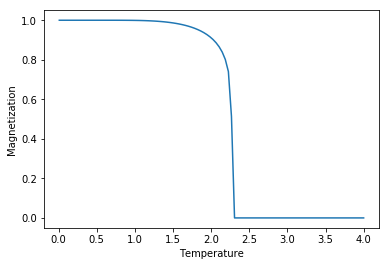

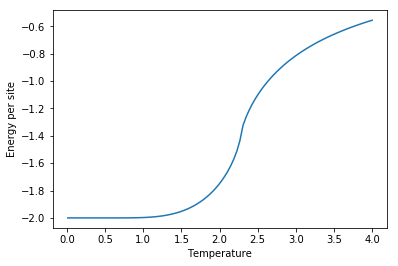

In [3]:
Tc = 1 / np.arctanh(np.sqrt(2)-1)
print("Critical temperature: %f" % Tc)

def m_theory(T,J):
    if J <=0 or T > Tc:
        return 0
    elif T < 0.2:
        return 1
    else:
        return (1 - np.sinh((2*J)/T)**(-4))**(1/8)
    
def e_theory(T,J):
    intgrl_N = 100
    a = (2*J)/T
    k = 1 / (np.sinh(a)**2)
    intgrl = np.sum(1.0/np.sqrt([(1-4*k*((1+k)**(-2))*((np.sin(th))**2)) \
                    for th in np.linspace(0,0.5*np.pi,intgrl_N)]))*(0.5*np.pi/intgrl_N)    
    return -J*(1/np.tanh(a)) * (1 + (2/np.pi)*(2* (np.tanh(a)**2) - 1) * intgrl)
    
x = np.linspace(0.01,4,100)
plt.plot(x,[m_theory(T,1)for T in x])
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.show()
                            
plt.plot(x,[e_theory(T,1)for T in x])
plt.xlabel("Temperature")
plt.ylabel("Energy per site")
plt.show()



# 2. Modelling approach

We will use Monte-Carlo method for modelling.

We will choose arbitrary element (with equal probability) and try to change its sign. Then we will calculate how energy changes from that action, and what is probability of such transition according to Bolzmann distribution.

So, let's assume that we have chosen element $(i,j)$. Let's denote energy of all system without this site $E_0$. Then energy before possible sig change is

$$E_{old} = E_0 -J S_{i,j} (S_{i,j-1} +S_{i,j+1}, S_{i-1,j}, S_{i+1,j}),$$

and energy after energy change is

$$E_{new} = E_0 +J S_{i,j} (S_{i,j-1} +S_{i,j+1}, S_{i-1,j}, S_{i+1,j}),$$

According to Bolzmann distribution, probability of state with energy $E$ is $Z^{-1} e^{-\frac{E}{T}}$. In our case there is only two states, so partition function $Z = E_{old} + E_{new}$, and probability of sign  change is:

$$p = \frac{e^{-\frac{E_{new}}{T}}}{e^{-\frac{E_{new}}{T}}+e^{-\frac{E_{old}}{T}}} = 
\frac{1}{1+e^{\frac{E_{new}-E_{old}}{T}}} = \frac{1}{1+e^{2J \Delta S /T}},$$

where $\Delta S = S_{i,j} (S_{i,j-1} +S_{i,j+1}+ S_{i-1,j}+ S_{i+1,j})$.

So, step of modelling is:

1. Choose random (i,j);

2. Calculate $\Delta S = S_{i,j} (S_{i,j-1} +S_{i,j+1} + S_{i-1,j} + S_{i+1,j})$;

3. Select uniformly $x \in [0,1]$;

4. If $x < \frac{1}{1+e^{2J \Delta S/T}}$, multiply $S_{i,j}$ on -1.

Let's notice that $\Delta S$ can take only integer values between $-4$ and $4$. It means we can for given temperatre calculate array of probabilities in advance, and don't do any floating-point operations during modelling.

**Modelling schedule**. We will perform simulated anneling: set big temperture (big enough to neglect interaction between elements), then slowly lower it. For each given temperature we will perform several groups of iterations. After each series we will calculate energy andmagnetization, and then average them.

# 3. Modelling of feromagnetic and paramagnetic

Let's model feromagnetic ($J=1$) and paramagnetic ($J=-1$) with N=100 and following schedule: 200 steps (from $T=10$ to $T=0.05$ with step $0.05$). For each step we do $10^6$ iterations, and repeat it 10 times. This makes $2 \cdot 10^9$ iterations in total.

We will use C program (see ising.c). It reads from standart input N,J. Then it reads schedule in triples: $T, c_1, c_2$, where T is temperature, $c_1$ is number of iterations in group, $c_2$ is number of groups.

Let's plot experimental data on the same chart with theoretical data.

In [10]:
def read_experimental_data(file, J):
    data = pd.read_csv(file, sep='\t', header=None)
    T, m, E = np.array(data[0]), np.array(data[1]), np.array(data[2])
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(T,m,'x')
    plt.plot(T,[m_theory(x, J) for x in T])
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')
    plt.ylim([0,1])
    plt.subplot(122)
    plt.plot(T,E, 'x')
    plt.plot(T,[e_theory(x, J) for x in T])
    plt.xlabel('Temperature')
    plt.ylabel('Energy per site')
    plt.show() 

In [172]:
os.system('gcc -o ising.exe ising.c')

0

Feromagnetic ($J=1$).

In [89]:
with open('in1.txt', 'w') as f:
    f.write('100\n1\n')
    for i in range(200):
        f.write("%f\t%d\t%d\n" % (10 - 0.05*i, 1000000,10))  

In [90]:
os.system('ising.exe < in1.txt > out1.txt')  

0

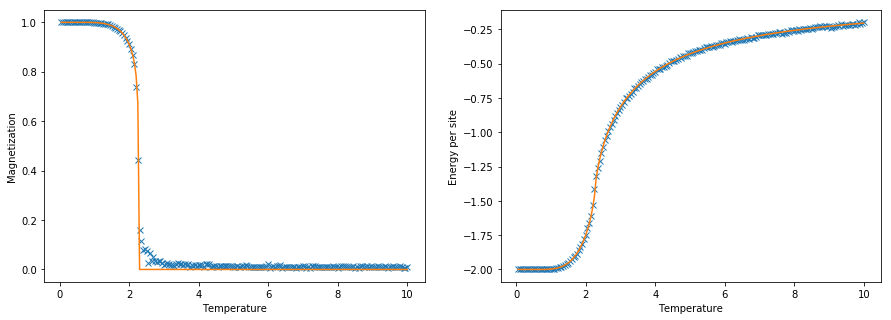

In [140]:
read_experimental_data('out1.txt',1)

Paramagnetic ($J=-1$).

In [143]:
with open('in2.txt', 'w') as f:
    f.write('100\n-1\n')
    for i in range(200):
        f.write("%f\t%d\t%d\n" % (10 - 0.05*i, 1000000,10))  

In [94]:
os.system('ising.exe < in2.txt > out2.txt') 

0

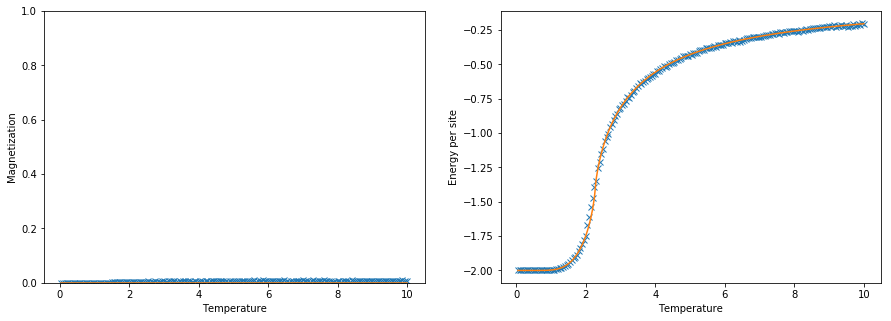

In [152]:
read_experimental_data('out2.txt',-1)

We see that experiment coincides with theory very well.

# 4. Speedup with CUDA

Let's measure performance of our C program. We know that schedule in file in1.txt takes $2 \cdot 10^9$ iterations. Let's count real time of modelling.

In [163]:
import time
 
time_start = time.time()
os.system('ising.exe < in1.txt') 
time_elpased = time.time() - time_start
print("Serial time: %fs." % time_elpased)
print("Serial performance: %f iterations per second." % (2e9 /time_elpased))

Serial time: 91.013844s.
Serial performance: 21974678.925874 iterations per second.


Now let's implement the same algorithm with CUDA. We will start $P$ threads for each group of iterations, and perform $c_1/P$ iterations in each thread (see source code in ising_cuda.cu).

This program reads schedule in the same format, but takes number of threads as first argument.

Note. As a result of integer division, we will do each time not 1000000 iterations, but less. But difference is always less than P (number of threads), and we can neglect it (while doing profiling) compared to number of itertions, which is $10^6$.

In [173]:
os.system('nvcc -o ising_cuda.exe ising_cuda.cu')

0

First of all, let's check that CUDA program gets correct results.

In [4]:
os.system('ising_cuda.exe 200 < in1.txt > out1_cuda.txt') 

0

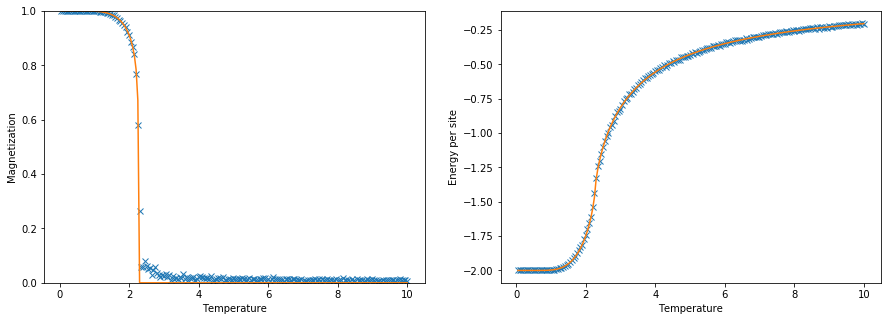

In [8]:
read_experimental_data('out1_cuda.txt',1)

Now let's see how performance changes with different number of threads.

In [2]:
import time
P_range = [10,20,30,40,60,80,100,120,140,160,180,200,220,240,256,300]
perf_range = []
for P in P_range:
    time_start = time.time()
    os.system('ising_cuda.exe %d < in1.txt > out1_cuda.txt' % P) 
    time_elpased = time.time() - time_start
    perf = 2e9 /time_elpased
    perf_range.append(perf)
    print("%d %f %f" % (P, time_elpased, perf))

10 112.550637 17769779.555785
20 61.421020 32562142.642994
30 44.140554 45309807.688661
40 34.089288 58669457.343706
60 23.618908 84677918.457522
80 18.248275 109599403.105439
100 15.416523 129730934.839736
120 13.416396 149071331.415272
140 12.090491 165419259.610004
160 12.141638 164722419.933927
180 12.101675 165266374.700159
200 11.410748 175273354.798097
220 11.061091 180813983.314071
240 10.629781 188150622.183230
256 10.378608 192704069.971960
300 10.322635 193748972.053505


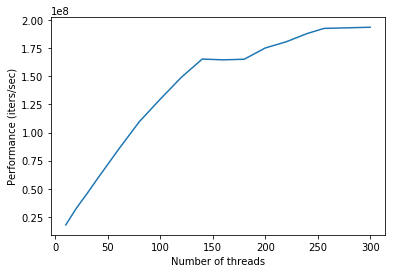

In [7]:
plt.plot(P_range, perf_range)
plt.xlabel("Number of threads")
plt.ylabel("Performance (iters/sec)")
plt.show()

So, with our CUDA program we can achieve performance only 9 times faster, using 200 threads.

Note. Looks like doing more clever paralellization can get better performance, because GPU has much more that 9 cores. But for that deeper understanding of CUDA and nVIDIA GPU architecture is needed. We can change not only number of "threads", but also number of "blocks". When I tried do that, I got wrong results. Maybe it's because different blocks correspnds to different parts of memory, and work with shared memory is allowed only within one block.

Also probably we can achieve increase, if we wouldn't retreive all $N^2$ values of spins from GPU after each group of iterations, but instead calculate and store results on GPU and retreive them all in the end. But for this work we have positive reuslt: it works correctly faster than CPU.

# 5. Phase transition in feromagnetic

Now, let's research phase transition in feromagnetic with higher resolution.
For that, let's create a schedule, which does modelling at temperatures from  2.27 to 2.26 with step $10^{-4}$, and does $6 \cdot 10^8$ iterations for each step. Here we will consider lattice with $N=256$.

Let's do modelling with CUDA.

In [11]:
with open('in3.txt', 'w') as f:
    f.write('256\n1\n')
    for i in range(270):
        f.write("%f\t%d\t%d\n" % (5 - 0.01*i, 10000000,3)) 
    for i in range(30):
        f.write("%f\t%d\t%d\n" % (2.3 - 0.001*i, 10000000,3)) 
    for i in range(100):  
        f.write("%f\t%d\t%d\n" % (2.27 - 0.0001*i, 10000000, 60)) 
    for i in range(60):  
        f.write("%f\t%d\t%d\n" % (2.26 - 0.001*i, 10000000, 3))
    for i in range(220):  
        f.write("%f\t%d\t%d\n" % (2.2 - 0.01*i, 10000000, 3))

In [45]:
os.system('ising_cuda.exe 200 < in3.txt > out3_cuda.txt') 

0

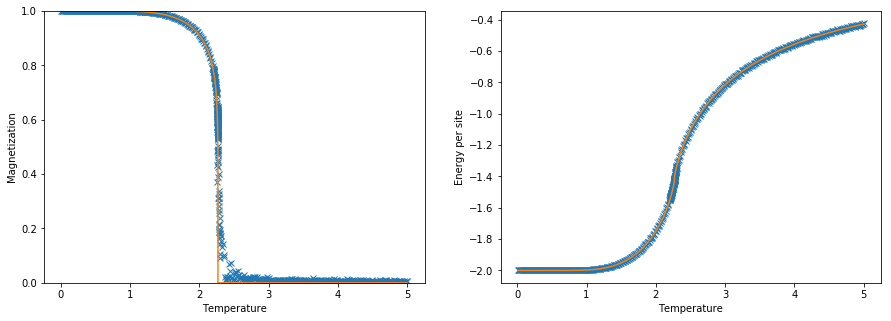

In [24]:
read_experimental_data('out3_cuda.txt', 1)

Let's zoom in interval $[2.20, 2.35]$.

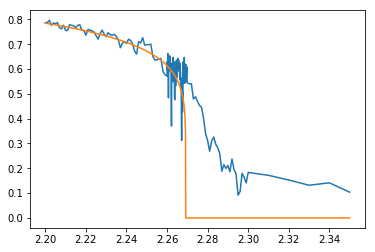

In [25]:
data = pd.read_csv('out3_cuda.txt', sep='\t', header=None)
T, m = np.array(data[0]), np.array(data[1])
T_zoomed = [T[i]  for i in range(len(T)) if (T[i]<=2.35 and T[i] >= 2.20)]
m_zoomed = [m[i]  for i in range(len(T)) if (T[i]<=2.35 and T[i] >= 2.20)]
plt.plot(T_zoomed, m_zoomed)
plt.plot(T_zoomed, [m_theory(x,1) for x in T_zoomed])
plt.show()

At that resolution we see that at segment $[T_c, 2.3]$ experimentally obtained behaviour significantly differs from theoretical. Spontaneous magnetization in eperiment appears before lattice is cooled down to Curie temperature, and when temperature reaches $T_c$, it already is about $0.5$.

Possible reason of that if $N$ being finite.

So, with that data we can't try to check asympthotic formula $m \sim (T_c-T)^{1/8}$, because $m$ doesn't tend to zero when $(T_c-T)$ tends to 0.

# 6. Modelling error depending on N

In previous experiment we explained discrepancy of experimental data with theory by finite $N$. Indeed, near Curie point correlation length in Ising model tends to infinity, and the fact that $N$ is finite becomes significant.

Let's do cooling down with the same schedule from $T=5$ to $T=2.5$ for different lattices 
(making in total $6000N^2$ steps, to ensure that we do the same number of spin swaps per site).

According to theory, $m(2.5)=0$, because $2.5 > T_c$. So, value of $m$ which we will get will be actually a modelling error.

In [26]:
N_range = list(range(10,1010,10))
m_range = []

for N in N_range:
    with open('in4.txt', 'w') as f:
        f.write('%d\n1\n' % N)
        f.write('5.0 %d 10\n' % (N*N*100))
        f.write('4.5 %d 10\n' % (N*N*100))
        f.write('4.0 %d 10\n' % (N*N*100))
        f.write('3.5 %d 10\n' % (N*N*100))
        f.write('3.0 %d 10\n' % (N*N*100))
        f.write('2.5 %d 10\n' % (N*N*100))
    os.system('ising_cuda.exe 200 < in4.txt > out4_cuda.txt') 
    data = pd.read_csv('out4_cuda.txt', sep='\t', header=None)
    m = np.array(data[1])[-1]
    m_range.append(m)

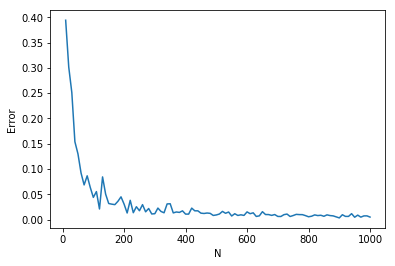

In [27]:
plt.plot(N_range, m_range)
plt.xlabel("N")
plt.ylabel("Error")
plt.show()

As we can see, error actually is decreasing as $N$ grows. Let's assume that $Error = \frac{1}{N^{\alpha}}. Let's build plot in logarythmic scale and estimate parameter $\alpha$.

0.914643849823


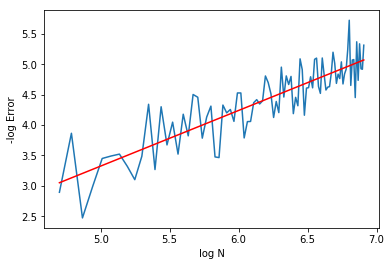

In [47]:
N_range_trunc = np.log(np.array(N_range[10:]))
m_log = -np.log(np.array(m_range[10:]))
c, alpha = np.linalg.lstsq(np.array([[1, N] for N in N_range_trunc]), m_log)[0]
print(alpha)
plt.plot(N_range_trunc, m_log) 
plt.plot(N_range_trunc, alpha*N_range_trunc+c , 'r', label='Fitted line')
plt.xlabel("log N")
plt.ylabel("-log Error")
plt.show()

So, $Error \sim \frac{1}{N^{0.9}}$.

# References

1. Yang C. N. The spontaneous magnetization of a two-dimensional Ising model //Physical Review. – 1952. – Т. 85. – №. 5. – С. 808.
2. Onsager L. Crystal statistics. I. A two-dimensional model with an order-disorder transition //Physical Review. – 1944. – Т. 65. – №. 3-4. – С. 117.
3. Ландау Л. Д., Лифшиц Е. М. Теоретическая физика. Том 5. Статистическая физика. Часть 1 //книга. – 1976.
4. Block B., Virnau P., Preis T. Multi-GPU accelerated multi-spin Monte Carlo simulations of the 2D Ising model //Computer Physics Communications. – 2010. – Т. 181. – №. 9. – С. 1549-1556.
